In [1]:
!pip install groq python-dotenv numpy tqdm datasets

In [2]:
from groq import Groq
from dotenv import load_dotenv
from datasets import load_dataset

import os
from tqdm import tqdm
import re
import random
import pprint

from typing import List, Dict, Any

load_dotenv()
random.seed(0)

client = Groq()
gsm8k_dataset = load_dataset("gsm8k", "main")

gsm8k_train = gsm8k_dataset["train"]
gsm8k_test  = gsm8k_dataset["test"]

In [3]:
def generate_response_using_Llama(
        prompt: str,
        model: str = "llama3-8b-8192"
    ):
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that solves math problems."
                },
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            model=model,
            temperature=0.3, ### 수정해도 됩니다!
            stream=False
        )
        return chat_completion.choices[0].message.content
    
    except Exception as e:
        print(f"API call error: {str(e)}")
        return None

#### 응답 잘 나오는지 확인해보기

In [4]:
response = generate_response_using_Llama(
    prompt="Hello world!",
)
print(response)

Hello! I'm excited to help you with any math problems you have. What kind of math are you working on? Do you have a specific problem you're stuck on or a concept you're trying to understand? Let me know and I'll do my best to assist you!


#### GSM8K 데이터셋 확인해보기

In [5]:
print("[Question]")
for l in gsm8k_test['question'][0].split("."):
    print(l)
print("="*100)
print("[Answer]")
print(gsm8k_test['answer'][0])

[Question]
Janet’s ducks lay 16 eggs per day
 She eats three for breakfast every morning and bakes muffins for her friends every day with four
 She sells the remainder at the farmers' market daily for $2 per fresh duck egg
 How much in dollars does she make every day at the farmers' market?
[Answer]
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18


#### Util 함수들
- extract_final_answer: LLM의 응답을 parse하여 최종 결과만 추출 (정답과 비교하기 위해)
- run_benchmark_test: 벤치마크 테스트
- save_final_result: 결과물 제출을 위한 함수

In [6]:
### 수정해도 됩니다!
def extract_final_answer(response: str):
    regex = r"(?:Answer:|Model response:|####)\s*\$?([0-9,]+)\b|([0-9,]+)\s*(meters|cups|miles|minutes)"
    matches = re.finditer(regex, response, re.MULTILINE)
    results = [match.group(1) if match.group(1) else match.group(2).replace(",", "") for match in matches]

    if len(results) == 0:
        additional_regex = r"\$?([0-9,]+)"
        additional_matches = re.finditer(additional_regex, response, re.MULTILINE)
        results.extend([match.group(1).replace(",", "") for match in additional_matches])

    return results[-1] if results else None

In [7]:
### 수정해도 됩니다!
def run_benchmark_test(
        dataset,
        prompt: str,
        model: str = "llama3-8b-8192",
        num_samples: int = 50,
        VERBOSE: bool = False
    ):
    correct = 0
    total   = 0
    results = []

    for i in tqdm(range(min(num_samples, len(dataset)))):
        question = dataset[i]["question"]
        correct_answer = float(re.findall(r'\d+(?:\.\d+)?', dataset[i]["answer"].split('####')[-1])[0])

        response = generate_response_using_Llama(
            prompt=prompt.format(question=question),
            model=model
        )

        if response:
            if VERBOSE:
                print("="*50)
                print(response)
                print("="*50)
            predicted_answer = extract_final_answer(response)

            if isinstance(predicted_answer, str):
                predicted_answer = float(predicted_answer.replace(",", ""))
            
            diff = abs(predicted_answer - correct_answer)
            is_correct = diff < 1e-5 if predicted_answer is not None else False
            
            if is_correct:
                correct += 1
            total += 1
            
            results.append({
                'question': question,
                'correct_answer': correct_answer,
                'predicted_answer': predicted_answer,
                'response': response,
                'correct': is_correct
            })

            if (i + 1) % 5 == 0:
                current_acc = correct/total if total > 0 else 0
                print(f"Progress: [{i+1}/{num_samples}]")
                print(f"Current Acc.: [{current_acc:.2%}]")

    return results, correct/total if total > 0 else 0

In [8]:
def save_final_result(results: List[Dict[str, Any]], accuracy: float, filename: str) -> None:
    result_str = f"====== ACCURACY: {accuracy} ======\n\n"
    result_str += f"[Details]\n"
    
    for idx, result in enumerate(results):
        result_str += f"Question {idx+1}: {result['question']}\n"
        result_str += f"Correct Answer: {result['correct_answer']}\n"
        result_str += f"Predicted Answer: {result['predicted_answer']}\n"
        result_str += f"Correct: {result['correct']}\n\n"
    
    with open(filename, "w", encoding="utf-8") as f:
        f.write(result_str)

#### Direct prompting with few-shot example

In [9]:
def construct_direct_prompt(num_examples: int = 3) -> str:
    train_dataset = gsm8k_train

    sampled_indices = random.sample(
        [i for i in range(len(train_dataset['question']))],
        num_examples
    )

    prompt = "Instruction:\nSolve the following mathematical question and generate ONLY the answer after a tag, 'Answer:' without any rationale.\n"

    for i in range(num_examples):
        cur_question = train_dataset['question'][i]
        cur_answer = train_dataset['answer'][i].split("####")[-1].strip()

        prompt += f"\n[Example {i+1}]\n"
        prompt += f"Question:\n{cur_question}\n"
        prompt += f"Answer:{cur_answer}\n"

    prompt += "\nQuestion:\n{question}\nAnswer:"

    return prompt

In [10]:
### 어떤 방식으로 저장되는지 확인해보세요!
PROMPT = construct_direct_prompt(3)
VERBOSE = False

results, accuracy = run_benchmark_test(
    dataset=gsm8k_test,
    prompt=PROMPT,
    VERBOSE=VERBOSE,
    num_samples=10
)
save_final_result(results, accuracy, "example.txt")

 50%|█████     | 5/10 [00:02<00:02,  2.14it/s]

Progress: [5/10]
Current Acc.: [20.00%]


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Progress: [10/10]
Current Acc.: [30.00%]


In [11]:
# TODO: 0 shot, 3 shot, 5 shot direct prompting을 통해 벤치마크 테스트를 한 후, 각각 direct_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 direct_prompting_5.txt
# 항상 num_samples=50 입니다!
### 어떤 방식으로 저장되는지 확인해보세요!
for i in [0, 3, 5]:
    PROMPT = construct_direct_prompt(i)
    VERBOSE = False

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )
    save_final_result(results, accuracy, f"direct_prompting_{i}.txt")

 10%|█         | 5/50 [00:02<00:21,  2.14it/s]

Progress: [5/50]
Current Acc.: [20.00%]


 20%|██        | 10/50 [00:04<00:19,  2.01it/s]

Progress: [10/50]
Current Acc.: [20.00%]


 30%|███       | 15/50 [00:06<00:12,  2.84it/s]

Progress: [15/50]
Current Acc.: [13.33%]


 40%|████      | 20/50 [00:08<00:11,  2.64it/s]

Progress: [20/50]
Current Acc.: [20.00%]


 50%|█████     | 25/50 [00:10<00:10,  2.48it/s]

Progress: [25/50]
Current Acc.: [20.00%]


 60%|██████    | 30/50 [00:12<00:09,  2.20it/s]

Progress: [30/50]
Current Acc.: [20.00%]


 70%|███████   | 35/50 [00:14<00:05,  2.99it/s]

Progress: [35/50]
Current Acc.: [17.14%]


 80%|████████  | 40/50 [00:16<00:04,  2.49it/s]

Progress: [40/50]
Current Acc.: [17.50%]


 90%|█████████ | 45/50 [00:19<00:02,  1.94it/s]

Progress: [45/50]
Current Acc.: [15.56%]


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Progress: [50/50]
Current Acc.: [18.00%]


 10%|█         | 5/50 [00:02<00:17,  2.53it/s]

Progress: [5/50]
Current Acc.: [20.00%]


 20%|██        | 10/50 [00:03<00:13,  2.88it/s]

Progress: [10/50]
Current Acc.: [20.00%]


 30%|███       | 15/50 [00:06<00:14,  2.42it/s]

Progress: [15/50]
Current Acc.: [13.33%]


 40%|████      | 20/50 [00:07<00:10,  2.83it/s]

Progress: [20/50]
Current Acc.: [15.00%]


 50%|█████     | 25/50 [00:09<00:09,  2.51it/s]

Progress: [25/50]
Current Acc.: [16.00%]


 60%|██████    | 30/50 [00:11<00:08,  2.48it/s]

Progress: [30/50]
Current Acc.: [16.67%]


 70%|███████   | 35/50 [00:13<00:05,  2.71it/s]

Progress: [35/50]
Current Acc.: [14.29%]


 80%|████████  | 40/50 [00:15<00:03,  2.68it/s]

Progress: [40/50]
Current Acc.: [12.50%]


 90%|█████████ | 45/50 [00:17<00:01,  2.57it/s]

Progress: [45/50]
Current Acc.: [13.33%]


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Progress: [50/50]
Current Acc.: [16.00%]


 10%|█         | 5/50 [00:03<00:34,  1.29it/s]

Progress: [5/50]
Current Acc.: [40.00%]


 20%|██        | 10/50 [00:09<00:44,  1.11s/it]

Progress: [10/50]
Current Acc.: [20.00%]


 30%|███       | 15/50 [00:13<00:29,  1.18it/s]

Progress: [15/50]
Current Acc.: [13.33%]


 40%|████      | 20/50 [00:19<00:32,  1.07s/it]

Progress: [20/50]
Current Acc.: [15.00%]


 50%|█████     | 25/50 [00:25<00:24,  1.01it/s]

Progress: [25/50]
Current Acc.: [20.00%]


 60%|██████    | 30/50 [00:29<00:17,  1.15it/s]

Progress: [30/50]
Current Acc.: [20.00%]


 70%|███████   | 35/50 [00:34<00:13,  1.13it/s]

Progress: [35/50]
Current Acc.: [17.14%]


 80%|████████  | 40/50 [00:41<00:13,  1.39s/it]

Progress: [40/50]
Current Acc.: [17.50%]


 90%|█████████ | 45/50 [00:48<00:08,  1.74s/it]

Progress: [45/50]
Current Acc.: [15.56%]


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

Progress: [50/50]
Current Acc.: [18.00%]


### Chain-of-Thought prompting with few-shot example
```text
[Question]
Janet’s ducks lay 16 eggs per day
 She eats three for breakfast every morning and bakes muffins for her friends every day with four
 She sells the remainder at the farmers' market daily for $2 per fresh duck egg
 How much in dollars does she make every day at the farmers' market?
====================================================================================================
[Answer]
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
```

[Answer] 아래의 정답을 도출하는 과정을 예시로 달아주면 CoT의 few shot이 되겠죠?

In [28]:
def construct_CoT_prompt(num_examples: int = 3) -> str:
    train_dataset = gsm8k_train

    sampled_indices = random.sample(
        [i for i in range(len(train_dataset['question']))],
        num_examples
    )
    prompt = "Instruction:\nFirst, think step-by-step about how to solve the mathematical question. Write down your thinking process in the 'Rationale' section.\nThen, provide ONLY the final numerical answer after the '####' separator.\n"

    for i in range(num_examples):
        cur_question = train_dataset['question'][i]
        cur_rationale = train_dataset['answer'][i].split("####")[0].strip()
        cur_answer = train_dataset['answer'][i].split("####")[-1].strip()

        prompt += f"\n[Example {i+1}]\n"
        prompt += f"Question:\n{cur_question}\n"
        prompt += f"Rationale: {cur_rationale}\n"
        prompt += f"#### {cur_answer}\n"

    prompt += "\nQuestion:\n{question}\nRationale:"

    return prompt

In [29]:
# TODO: 0 shot, 3 shot, 5 shot CoT prompting을 통해 벤치마크 테스트를 한 후, 각각 CoT_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 CoT_prompting_5.txt
# 항상 num_samples=50 입니다!
for i in [0, 3, 5]:
    PROMPT = construct_CoT_prompt(i)
    VERBOSE = False

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )
    save_final_result(results, accuracy, f"CoT_prompting_{i}.txt")

 10%|█         | 5/50 [00:04<00:43,  1.03it/s]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [00:07<00:27,  1.43it/s]

Progress: [10/50]
Current Acc.: [60.00%]


 30%|███       | 15/50 [00:12<00:30,  1.15it/s]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [00:16<00:32,  1.09s/it]

Progress: [20/50]
Current Acc.: [65.00%]


 50%|█████     | 25/50 [00:18<00:12,  2.01it/s]

Progress: [25/50]
Current Acc.: [68.00%]


 60%|██████    | 30/50 [00:21<00:11,  1.79it/s]

Progress: [30/50]
Current Acc.: [70.00%]


 70%|███████   | 35/50 [00:24<00:09,  1.62it/s]

Progress: [35/50]
Current Acc.: [74.29%]


 80%|████████  | 40/50 [00:28<00:06,  1.59it/s]

Progress: [40/50]
Current Acc.: [70.00%]


 90%|█████████ | 45/50 [00:32<00:04,  1.12it/s]

Progress: [45/50]
Current Acc.: [68.89%]


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Progress: [50/50]
Current Acc.: [70.00%]


 10%|█         | 5/50 [00:04<00:33,  1.33it/s]

Progress: [5/50]
Current Acc.: [60.00%]


 20%|██        | 10/50 [00:08<00:29,  1.34it/s]

Progress: [10/50]
Current Acc.: [60.00%]


 30%|███       | 15/50 [00:15<01:05,  1.86s/it]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [00:18<00:21,  1.38it/s]

Progress: [20/50]
Current Acc.: [65.00%]


 50%|█████     | 25/50 [00:22<00:24,  1.01it/s]

Progress: [25/50]
Current Acc.: [68.00%]


 60%|██████    | 30/50 [00:25<00:13,  1.47it/s]

Progress: [30/50]
Current Acc.: [73.33%]


 70%|███████   | 35/50 [00:30<00:13,  1.07it/s]

Progress: [35/50]
Current Acc.: [77.14%]


 80%|████████  | 40/50 [00:34<00:08,  1.18it/s]

Progress: [40/50]
Current Acc.: [75.00%]


 90%|█████████ | 45/50 [00:38<00:04,  1.16it/s]

Progress: [45/50]
Current Acc.: [77.78%]


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Progress: [50/50]
Current Acc.: [78.00%]


 10%|█         | 5/50 [00:02<00:27,  1.66it/s]

Progress: [5/50]
Current Acc.: [60.00%]


 20%|██        | 10/50 [00:06<00:27,  1.45it/s]

Progress: [10/50]
Current Acc.: [70.00%]


 30%|███       | 15/50 [00:09<00:19,  1.84it/s]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [00:12<00:16,  1.83it/s]

Progress: [20/50]
Current Acc.: [65.00%]


 50%|█████     | 25/50 [00:15<00:20,  1.23it/s]

Progress: [25/50]
Current Acc.: [64.00%]


 60%|██████    | 30/50 [00:18<00:11,  1.68it/s]

Progress: [30/50]
Current Acc.: [70.00%]


 70%|███████   | 35/50 [00:22<00:10,  1.45it/s]

Progress: [35/50]
Current Acc.: [74.29%]


 80%|████████  | 40/50 [00:29<00:11,  1.18s/it]

Progress: [40/50]
Current Acc.: [72.50%]


 90%|█████████ | 45/50 [00:33<00:04,  1.01it/s]

Progress: [45/50]
Current Acc.: [75.56%]


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]

Progress: [50/50]
Current Acc.: [76.00%]


### Construct your prompt!!

목표: 본인만의 프롬프트를 통해 정답률을 더 끌어올려보기!
- gsm8k의 train 데이터셋에서 예시를 가져온 다음 (자유롭게!)
- 그 예시들에 대한 풀이 과정을 만들어주세요!
- 모든 것들이 자유입니다! Direct Prompting, CoT Prompting을 한 결과보다 정답률만 높으면 돼요.

In [30]:
DUPS_PROMPT = """Perform the following actions:
1 - Extract core question from following question delimited by triple backticks with 1 sentence, only the most comprehensive and detailed one!
2 - Extract the the most useful information related to the core question from the same question delimited by triple backticks and list them one by one!
3 - Answer of the question delimited by triple backticks with fully and comprehensively considering the core question and useful information. \
    Make sure resolve these custom variables used in the reasoning process.
4 - Provide the final numerical answer after the '####' separator.

Use the following format:
Core Question: <extracted core question>
Hints: <extracted useful information, listed one by one>
Reason Steps: <the reasoning steps to get the final answer>
#### <final answer>


"""

In [31]:
### 자유롭게 수정해도 됩니다! 완전히 새로 함수를 만들어도 돼요.
def construct_my_prompt(example_list: list[str], num_examples: int = 3):
    # TODO: 구현해주세요!
    prompt = DUPS_PROMPT

    for i in range(num_examples):
        prompt += f"{example_list[i]}\n\n\n"
    prompt += "Question: ```{question}```"

    return prompt

In [32]:
from DUPS_examples import DUPS_EXAMPLES
example_list = list(map(str, DUPS_EXAMPLES))

In [33]:
# TODO: 만든 0 shot, 3 shot, 5 shot example과 프롬프트를 통해 벤치마크 테스트를 한 후, 각각 My_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 My_prompting_5.txt
# 항상 num_samples=50 입니다!
for i in [0, 3, 5]:
    PROMPT = construct_my_prompt(example_list, i)
    VERBOSE = False

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )
    save_final_result(results, accuracy, f"My_prompting_{i}.txt")

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [00:10<00:33,  1.21it/s]

Progress: [10/50]
Current Acc.: [60.00%]


 30%|███       | 15/50 [00:16<00:41,  1.20s/it]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [00:23<00:48,  1.61s/it]

Progress: [20/50]
Current Acc.: [65.00%]


 50%|█████     | 25/50 [00:32<00:50,  2.03s/it]

Progress: [25/50]
Current Acc.: [64.00%]


 60%|██████    | 30/50 [00:41<00:33,  1.68s/it]

Progress: [30/50]
Current Acc.: [66.67%]


 70%|███████   | 35/50 [00:45<00:14,  1.02it/s]

Progress: [35/50]
Current Acc.: [71.43%]


 80%|████████  | 40/50 [00:51<00:15,  1.51s/it]

Progress: [40/50]
Current Acc.: [72.50%]


 90%|█████████ | 45/50 [00:55<00:04,  1.14it/s]

Progress: [45/50]
Current Acc.: [75.56%]


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Progress: [50/50]
Current Acc.: [76.00%]


 10%|█         | 5/50 [00:06<00:50,  1.11s/it]

Progress: [5/50]
Current Acc.: [100.00%]


 20%|██        | 10/50 [00:13<01:02,  1.57s/it]

Progress: [10/50]
Current Acc.: [80.00%]


 30%|███       | 15/50 [00:22<00:49,  1.42s/it]

Progress: [15/50]
Current Acc.: [73.33%]


 40%|████      | 20/50 [00:29<00:48,  1.63s/it]

Progress: [20/50]
Current Acc.: [70.00%]


 50%|█████     | 25/50 [00:37<00:36,  1.44s/it]

Progress: [25/50]
Current Acc.: [72.00%]


 60%|██████    | 30/50 [00:41<00:16,  1.20it/s]

Progress: [30/50]
Current Acc.: [76.67%]


 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

Progress: [35/50]
Current Acc.: [80.00%]


 80%|████████  | 40/50 [00:55<00:13,  1.32s/it]

Progress: [40/50]
Current Acc.: [77.50%]


 90%|█████████ | 45/50 [01:04<00:10,  2.18s/it]

Progress: [45/50]
Current Acc.: [80.00%]


100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


Progress: [50/50]
Current Acc.: [80.00%]


 10%|█         | 5/50 [00:04<00:37,  1.20it/s]

Progress: [5/50]
Current Acc.: [100.00%]


 20%|██        | 10/50 [00:08<00:38,  1.04it/s]

Progress: [10/50]
Current Acc.: [80.00%]


 30%|███       | 15/50 [00:15<00:39,  1.13s/it]

Progress: [15/50]
Current Acc.: [73.33%]


 40%|████      | 20/50 [00:21<00:36,  1.21s/it]

Progress: [20/50]
Current Acc.: [80.00%]


 50%|█████     | 25/50 [00:25<00:23,  1.08it/s]

Progress: [25/50]
Current Acc.: [76.00%]


 60%|██████    | 30/50 [00:50<02:15,  6.79s/it]

Progress: [30/50]
Current Acc.: [80.00%]


 70%|███████   | 35/50 [00:57<00:33,  2.26s/it]

Progress: [35/50]
Current Acc.: [82.86%]


 80%|████████  | 40/50 [01:05<00:17,  1.75s/it]

Progress: [40/50]
Current Acc.: [80.00%]


 90%|█████████ | 45/50 [01:12<00:06,  1.40s/it]

Progress: [45/50]
Current Acc.: [82.22%]


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]

Progress: [50/50]
Current Acc.: [82.00%]


### 보고서 작성하기
#### 아래의 내용이 포함되면 됩니다!

1. Direct Prompting, CoT Prompting, My Prompting을 0 shot, 3 shot, 5 shot 정답률을 표로 보여주세요!
2. CoT Prompting이 Direct Prompting에 비해 왜 좋을 수 있는지에 대해서 서술해주세요!
3. 본인이 작성한 프롬프트 기법이 CoT에 비해서 왜 더 좋을 수 있는지에 대해서 설명해주세요!
4. 최종적으로, `PROMPTING.md`에 보고서를 작성해주세요!

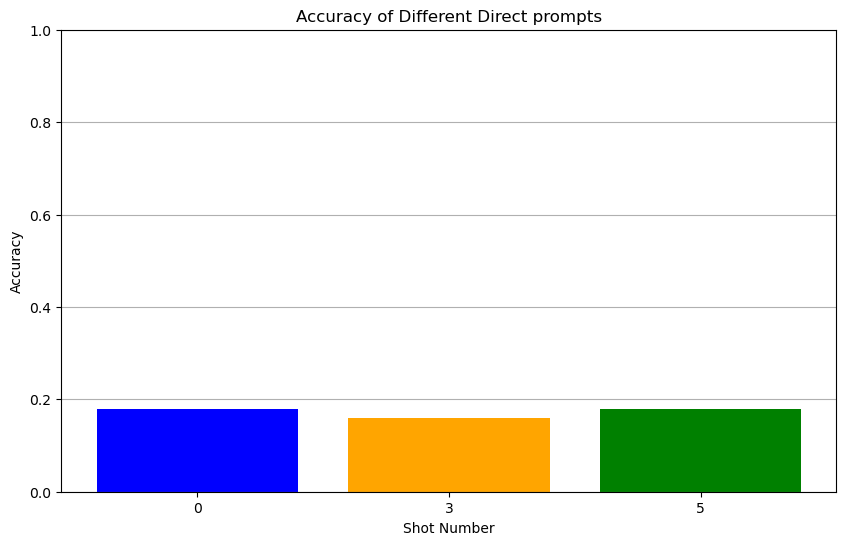

In [34]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracies: List[float], shots: List[str], prompt_type: str = "Prompting Type"):
    plt.figure(figsize=(10, 6))
    plt.bar(shots, accuracies, color=['blue', 'orange', 'green'])
    plt.xlabel('Shot Number')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Different {prompt_type} prompts')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.savefig(f"docs/{prompt_type}_accuracy.png")
    plt.show()

shot_list = ['0', '3', '5']
accuracy_list = [0.18, 0.16, 0.18]
plot_accuracy(accuracy_list, shot_list, prompt_type="Direct")

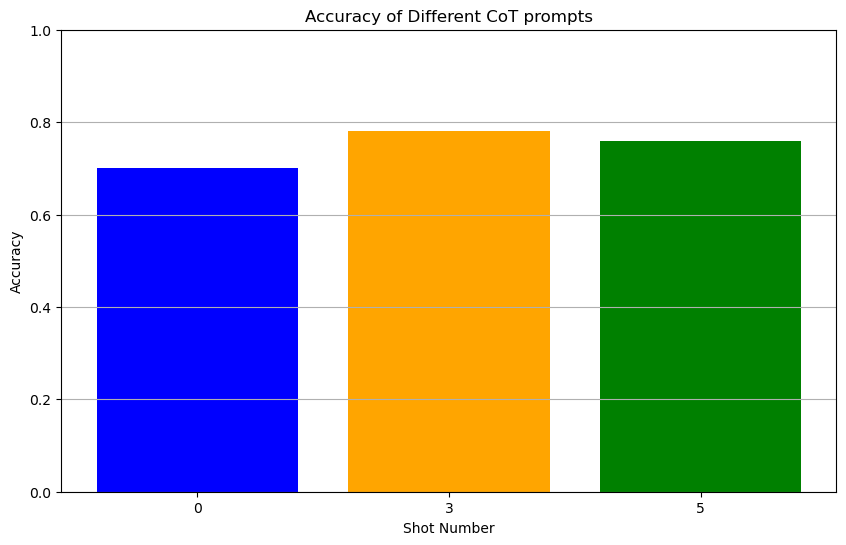

In [35]:
accuracy_list = [0.7, 0.78, 0.76]
plot_accuracy(accuracy_list, shot_list, prompt_type="CoT")

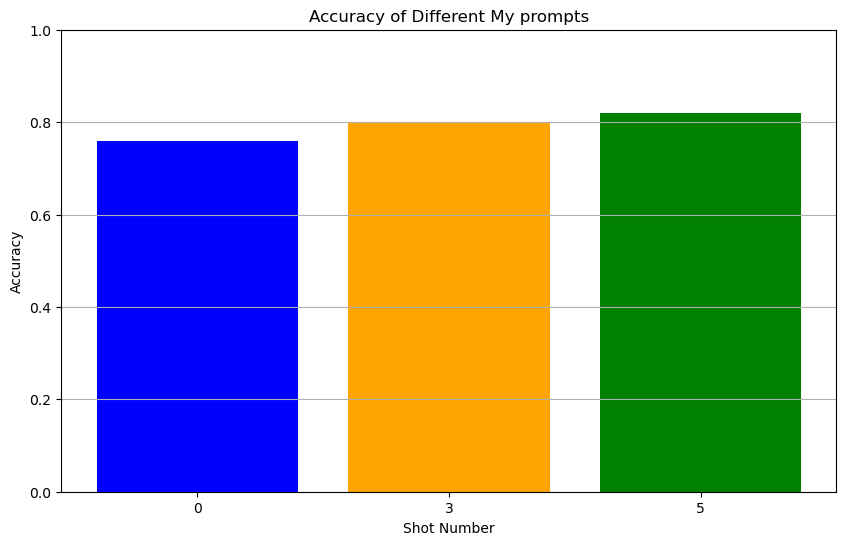

In [36]:
# My prompting accuracy
accuracy_list = [0.76, 0.8, 0.82]
plot_accuracy(accuracy_list, shot_list, prompt_type="My")

In [37]:
def save_example_from_result(results: List[Dict[str, Any]], accuracy: float, filename: str) -> None:
    result_str = f"====== ACCURACY: {accuracy} ======\n\n"
    result_str += f"[Details]\n"
    correct_results = [result for result in results if result['correct']]
    incorrect_results = [result for result in results if not result['correct']]
    
    for idx, result in enumerate(correct_results + incorrect_results):
        if idx < len(correct_results):
            result_str += f"\n[Example {idx+1}]\n"
        else:
            result_str += f"\n[Incorrect Example {idx+1 - len(correct_results)}]\n"
        
        result_str += f"Question: {result['question']}\n"
        result_str += f"{result['response']}\n\n"


    with open(filename, "w", encoding="utf-8") as f:
        f.write(result_str)